In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

In [159]:
# fix random seed for reproducibility
np.random.seed(7)

In [160]:
# load the dataset
df = pd.read_csv('exchange_rate.csv')


In [161]:
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.loc[:,['Date', 'PLN']]
df

,Date,PLN
0,2020-04-25,4.192963
1,2020-04-24,4.192963
2,2020-04-23,4.212681
3,2020-04-22,4.173093
4,2020-04-21,4.179293
...,...,...
1455,2016-05-01,3.855564
1456,2016-04-30,3.855564
1457,2016-04-29,3.855564
1458,2016-04-28,3.863356


In [162]:
dataset = df['PLN'].values
dataset = dataset.reshape(dataset.shape[0],1)
print(dataset)
print('Shape: ', dataset.shape)
print('Type: ', dataset.dtype)

[[4.19296296]
 [4.19296296]
 [4.21268102]
 ...
 [3.85556433]
 [3.86335622]
 [3.88551712]]
Shape:  (1460, 1)
Type:  float64


In [163]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.9173964 ],
       [0.9173964 ],
       [0.9382236 ],
       ...,
       [0.56101922],
       [0.56924941],
       [0.59265685]])

In [164]:
# split into train and test sets
percent = 0.67
train_size = int(len(dataset) * percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

978 482


In [165]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY, baseLine = [], [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    trainX = np.array(dataX)
    trainY = np.array(dataY)
    trainY = trainY.reshape(trainY.shape[0], 1)
    return trainX, trainY

In [166]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print('trainX.shape: ', trainX.shape)
print('trainY.shape: ', trainY.shape)

trainX.shape:  (977, 1)
trainY.shape:  (977, 1)


In [173]:
def create_baseline(dataset, look_back=1):
    baseline = []
    invDataset = scaler.inverse_transform(dataset)
    for i in range(len(dataset)-look_back):
        baseline.append(invDataset[i+look_back-1, 0])
    baseline = np.array(baseline)
    baseline = baseline.reshape(baseline.shape[0], 1)
    return baseline

In [168]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [34]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 2s - loss: 0.0353
Epoch 2/100
 - 1s - loss: 0.0040
Epoch 3/100
 - 1s - loss: 4.7096e-04
Epoch 4/100
 - 1s - loss: 3.7825e-04
Epoch 5/100
 - 1s - loss: 3.8139e-04
Epoch 6/100
 - 1s - loss: 3.8709e-04
Epoch 7/100
 - 1s - loss: 3.8246e-04
Epoch 8/100
 - 1s - loss: 3.9030e-04
Epoch 9/100
 - 1s - loss: 3.9115e-04
Epoch 10/100
 - 1s - loss: 3.9170e-04
Epoch 11/100
 - 1s - loss: 3.8289e-04
Epoch 12/100
 - 1s - loss: 3.8559e-04
Epoch 13/100
 - 1s - loss: 3.8145e-04
Epoch 14/100
 - 1s - loss: 3.8586e-04
Epoch 15/100
 - 1s - loss: 3.8035e-04
Epoch 16/100
 - 1s - loss: 3.8516e-04
Epoch 17/100
 - 1s - loss: 3.8629e-04
Epoch 18/100
 - 1s - loss: 3.9966e-04
Epoch 19/100
 - 1s - loss: 3.8804e-04
Epoch 20/100
 - 1s - loss: 3.8546e-04
Epoch 21/100
 - 1s - loss: 3.8997e-04
Epoch 22/100
 - 1s - loss: 3.7671e-04
Epoch 23/100
 - 1s - loss: 3.7248e-04
Epoch 24/100
 - 1s - lo

In [36]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredictInv = scaler.inverse_transform(trainPredict)
trainYInv = scaler.inverse_transform(trainY)
testPredictInv = scaler.inverse_transform(testPredict)
testYInv = scaler.inverse_transform(testY)
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
#print('Test Score: %.2f RMSE' % (testScore))

In [183]:
def mean_absolute_percentage_error(y_true, y_pred):
    #y_true[y_true == 0.0] = 1e-20
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [191]:
trainScore = mean_absolute_percentage_error(trainPredictInv, trainYInv)
print('Train Score: %.5f MAPE' % (trainScore))
testScore = mean_absolute_percentage_error(testPredictInv, testYInv)
print('Test Score: %.5f MAPE' % (testScore))
#baseLine
trainBaseline = baseline[0:trainPredictInv.shape[0],:]
testBaseline = baseline[trainPredictInv.shape[0]+look_back:len(baseline),:]
print(trainBaseline.shape)
print(testBaseline.shape)

trainScore = mean_absolute_percentage_error(trainBaseline, trainYInv)
print('Train BaseLine Score: %.5f MAPE' % (trainScore))
testScore = mean_absolute_percentage_error(testBaseline, testYInv)
print('Test BaseLine Score: %.5f MAPE' % (testScore))

trainScore = math.sqrt(mean_squared_error(trainPredictInv, trainYInv))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testPredictInv, testYInv))
print('Test Score: %.5f RMSE' % (testScore))

#baseLine
trainScore = math.sqrt(mean_squared_error(trainBaseline, trainYInv))
print('Train Baseline Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testBaseline, testYInv))
print('Test Baseline Score: %.5f RMSE' % (testScore))


trainScore = mean_absolute_error(trainPredictInv, trainYInv)
print('Train Score: %.5f MAE' % (trainScore))
testScore = mean_absolute_error(testPredictInv, testYInv)
print('Test Score: %.5f MAE' % (testScore))

#baseLine
trainScore = mean_absolute_error(trainBaseline, trainYInv)
print('Train Baseline Score: %.5f MAE' % (trainScore))
testScore = mean_absolute_error(testBaseline, testYInv)
print('Test Baseline Score: %.5f MAE' % (testScore))

Train Score: 0.42991 MAPE
Test Score: 0.45947 MAPE
(977, 1)
(481, 1)
Train BaseLine Score: 0.29096 MAPE
Test BaseLine Score: 0.32862 MAPE
Train Score: 0.02067 RMSE
Test Score: 0.02446 RMSE
Train Baseline Score: 0.01725 RMSE
Test Baseline Score: 0.02182 RMSE
4.2564573
Train Score: 0.01615 MAE
Test Score: 0.01810 MAE
Train Baseline Score: 0.01087 MAE
Test Baseline Score: 0.01292 MAE


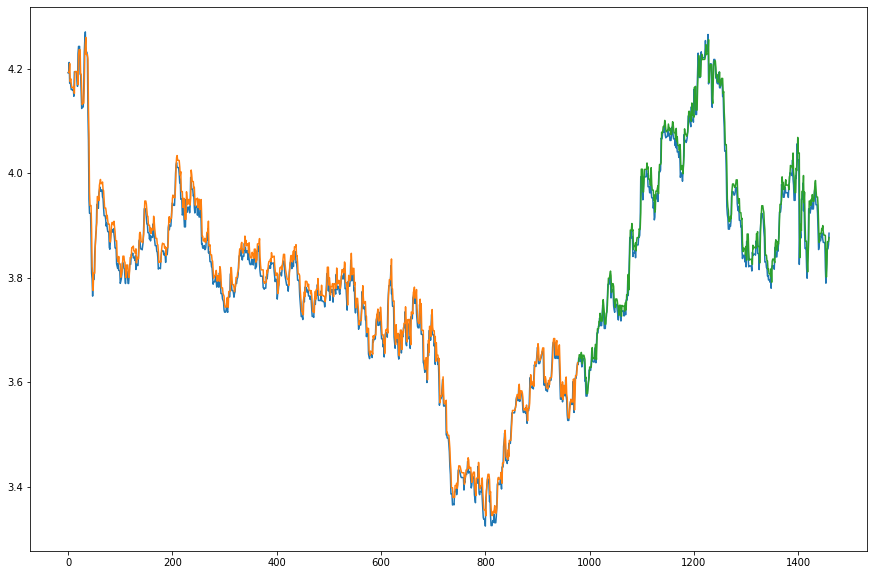

In [82]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredictInv)+look_back, :] = trainPredictInv
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredictInv)+look_back+1:len(dataset), :] = testPredictInv
# plot baseline and predictions
plt.figure(figsize=(15, 10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [107]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=df.PLN, mode='lines', name='original'))
fig.add_trace(go.Scatter(y=trainPredictPlot[:,0], mode='lines', name='train'))
fig.add_trace(go.Scatter(y=testPredictPlot[:,0], mode='lines', name='test'))
fig.add_trace(go.Scatter(y=baseline[:,0], mode='lines', name='baseline'))
fig.update_layout(showlegend=True)
fig.show()

In [197]:
trainPredictInv[0:5,:]

array([[4.19353  ],
       [4.19353  ],
       [4.2107596],
       [4.17595  ],
       [4.181459 ]], dtype=float32)

In [198]:
trainYInv[0:5,:]

array([[4.19296296],
       [4.21268102],
       [4.17309285],
       [4.17929316],
       [4.16869245]])

In [170]:
baseline

array([[4.21268102],
       [4.17309285],
       [4.17929316],
       ...,
       [3.85556433],
       [3.86335622],
       [3.88551712]])

In [106]:
invDataset = scaler.inverse_transform(dataset)
invDataset

array([[4.19296296],
       [4.19296296],
       [4.21268102],
       ...,
       [3.85556433],
       [3.86335622],
       [3.88551712]])

In [120]:
trainPredictInv.shape[0] + testPredictInv.shape[0]

1458

In [132]:
trainPredict.shape

(977, 1)

In [133]:
testPredict.shape

(481, 1)

In [142]:
invDataset[55,0]

3.9408763779

In [143]:
baseline[55, 0]

3.9408763779

In [177]:
bl = pd.DataFrame(data=baseline)
bl

,0
0,4.192963
1,4.192963
2,4.212681
3,4.173093
4,4.179293
...,...
1454,3.813887
1455,3.855564
1456,3.855564
1457,3.855564


In [172]:
ds = pd.DataFrame(data=invDataset)
ds

,0
0,4.192963
1,4.192963
2,4.212681
3,4.173093
4,4.179293
...,...
1455,3.855564
1456,3.855564
1457,3.855564
1458,3.863356
